# Simple droughts workflow

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_2.ipynb) to launch this workflow on MyBinder. 

This is the second and simpler drought workflow.  

## Risk assessment methodology

The approach is to calculate the exposed vulnerable population to the drought. This can be done by overlying the hazard data of drought, expressed as Combined Drought Indicator (CDI), and population data. 

:::{tip} Hazard data
**The Combined Drought Indicator (CDI)** that is implemented in the European Drought Observatory (EDO) is used to identify areas affected by agricultural drought, and areas with the potential to be affected. CDI can be downloaded from the [Copernicus data server](https://edo.jrc.ec.europa.eu/gdo/php/index.php?id=2112) and is derived by combining three drought indicators produced operationally in the EDO framework - namely the 
- **Standardized Precipitation Index (SPI)**,
- **the Soil Moisture Anomaly (SMA)**, and
- **the FAPAR Anomaly** - in such a way that areas are classified according to three primary drought classes:
  1. “Watch” - indicating that precipitation is less than normal;
  2. “Warning” - indicating that soil moisture is in deficit; and
  3. “Alert” - indicating that vegetation shows signs of stress.  
  ##### Two additional classes - namely
  4. “Partial recovery” and
  5. “Recovery” - identify the stages of the vegetation recovery process. 

Standardized Precipitation Index (SPI): The SPI indicator measures precipitation anomalies at a given location, based on a comparison of observed total precipitation amounts for an accumulation period of interest (e.g. 1, 3, 12, 48 months), with the long-term historic rainfall record for that period (McKee et al., 1993; Edwards and McKee, 1997). 

Soil Moisture Anomaly (SMA): The SMA indicator is derived from anomalies of estimated daily soil moisture (or soil water) content - represented as standardized soil moisture index (SMI) - which is produced by the JRC’s LISFLOOD hydrological model, and which has been shown to be effective for drought detection purposes (Laguardia and Niemeyer, 2008).  

FAPAR Anomaly: The FAPAR Anomaly indicator is computed as deviations of the biophysical variable Fraction of Absorbed Photosynthetically Active Radiation (FAPAR), composited for 10- day intervals, from long-term mean values. Satellite-measured FAPAR represents the fraction of incident solar radiation that is absorbed by land vegetation for photosynthesis, and is effective for detecting and assessing drought impacts on vegetation canopies (Gobron et al., 2005). 

:::{list-table} Classification scheme
:widths: 15 10 40
:header-rows: 1

*   - LEVEL
    - COLOUR
    - CLASIFICATION CONDITION
*   - Watch
    - yellow
    - SPI-3 <-1 or SPI-1 < -2
*   - Warning
    - orange
    - SMA <-1 and (SPI-3 < -1 or SPI-1 < -2)
*   - Alert
    - red
    - {math}`\Delta`FAPAR < -1 and (SPI-3 < -1 or SPI-1 < -2)
*   - Partial recovery
    - brown
    - ({math}`\Delta`FAPAR < -1 and (SPI-3{sub}`m-1` < -1 or SPI-3 > -1) or\
      ({math}`\Delta`FAPAR < -1 and (SPI-1{sub}`m-1` < -2 or SPI-1 > -2)
*   - Full recovery
    - grey
    - (SPI-3{sub}`m-1` < -1 and SPI-3 > -1) or\
      (SPI-1{sub}`m-1` < -2 or SPI-1 > -2)
:::

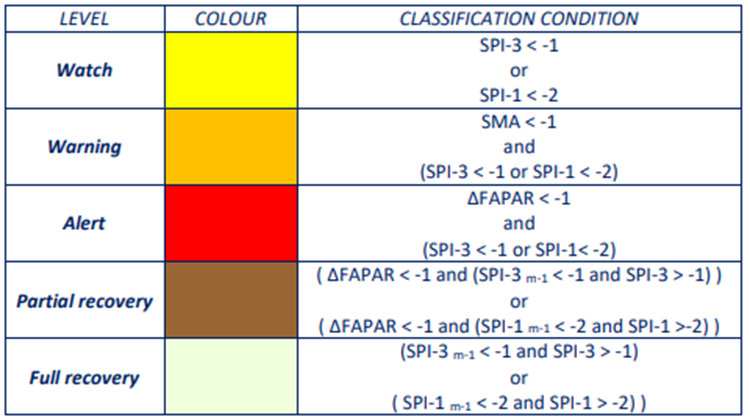

**Exposure**  
Exposure is assessed by overlaying the European population density map at 1000 m resolution using the [Global Human Settlement Population dataset](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop) dataset. 

### Load libraries

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
- [matplotlib](https://matplotlib.org/) - For plotting as well

In [1]:
import os
import pooch

import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'drought_workflow' in the same directory where this notebook is saved.

The cell after will create the **data** directory inside the **drought_workflow**.

In [2]:
workflow_folder = 'drought_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [3]:
data_dir = os.path.join(workflow_folder,'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Download data

In this workflow we will have a mix of data that is available to download from the notebook, and the data that has to be manually downloaded on the website.

Since there is no API to download this data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to donwload and unzip it.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

### Population data
First we need the information on the population. We will download it from the JRC data portal.  
Once the data is downloaded and unzipped, Pooch will list the content of the directory with the data.  

In this example we are using population data from JRC data portal - the Global Human Settlement Layer (GHSL). Note that this dataset is available in 100m resolution as well.

We are downloading global data, but it is also available in regional grid.

In [ ]:
url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2030_GLOBE_R2023A_54009_1000/V1-0/GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.zip'
pooch.retrieve(
    url=url,
    known_hash='a47d7d587b2607c62bbffed4b05521ca9bd7be7d431bcfac7e33286954a68d3c',
    path=data_dir,
    processor=pooch.Unzip(extract_dir=''))

The zip file contains data, as well as metadata and the documentation in the pdf file.

### The Combined Drought Indicator (CDI)

Unfortunately, this dataset must be manually downloaded from the [Copernicus Drought Observatory data server](https://edo.jrc.ec.europa.eu/gdo/php/index.php?id=2112). Here we will use all the fully available years (2012-2022).  
To download the data, select all years and click **Download**. Save the data in the **data_dir** folder.

Note that now we have a directory **drought_workflow/data** where all the zip files and unzipped files are (or should be).  
We can list all the files in the **data_dir** using the os library.  

In [ ]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Population data
Population data is in file with filename: GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif

We can use rioxaray to load this file.

In [6]:
filename_population = f'{data_dir}/GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif'

population = rxr.open_rasterio(filename_population)
population

<xarray.DataArray (band: 1, y: 18000, x: 36082)>
[649476000 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.804e+07 -1.804e+07 ... 1.804e+07 1.804e+07
  * y            (y) float64 9e+06 8.998e+06 8.998e+06 ... -8.998e+06 -9e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        452635.11543083
    STATISTICS_MEAN:           61.892180872876
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         767.17038013196
    STATISTICS_VALID_PERCENT:  21.26
    _FillValue:                -200.0
    scale_factor:              1.0
    add_offset:                0.0

:::{tip} Explore the file content
Fell free to explore the content and structure of the dataset.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics👆 (click)
:class: dropdown
👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the information about projection of this dataset.  
👋 Click on **Attributes** to find the STATISTICS attributes including minimum, maximum and other statistics

:::

One thing you might notice that is missing for this dataset is the units for the population data.  
This information can be found in the [technical documentation of the dataset](https://ghsl.jrc.ec.europa.eu/ghs_pop2023.php).

We can read that values are expressed as decimals (Float) and represent the absolute number of inhabitants of the cell.

### The Combined Drought Indicator (CDI)

All the downloaded netcdf files are stored in our **data_dir** folder, with filenames starting with: **cdinx_m_euu_**, followed by the start and end date period, and ending with **_t.nc**.  
First we can explore one of them.

In [7]:
cdi_nc = xr.open_dataset(f"{data_dir}/cdinx_m_euu_20220101_20221221_t.nc")
cdi_nc

<xarray.Dataset>
Dimensions:  (time: 36, lat: 950, lon: 1000)
Coordinates:
  * lat      (lat) int64 5497500 5492500 5487500 ... 762500 757500 752500
  * lon      (lon) int64 2502500 2507500 2512500 ... 7487500 7492500 7497500
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
Data variables:
    cdinx    (time, lat, lon) float32 ...
    3035     float32 ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2023-06-23
    01.title:                   Combined Drought Indicator (CDI), v.3.0.1
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  https://data.jrc.ec.europa.eu/dataset/afa8a5e...
    19.sample_url:              /images/map_examples/dbio_data_previews/cdinx...
    20.metadata_last_updated:   2023-04-05
    21.values_legend:           0: No drought, 1: Watch. Precipitation defici...
    22.version_notes:           Current version: Version 3.0.1 covers data fr...

We can notice that there are 36 time stamps for 12 months in the year 2022.  
This is because this index is caluclated from the satellite data that takes 10 days to collect the information over the globe. Each time step has index calculated over the previous 10 days.

:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics👆 (click)
:class: dropdown
👋 Click on **3035** 📄 _show/hide attributes_ to see the information about projection of this dataset.  
👋 Click on **Attributes** to find the extensive metadata including projection, resolution, extent, links to documentation, data catalogue etc

:::

## Process the data

In this workflow we want to overlay the population and drought data, to have a better understanding where are densely populated area affected by the drought.

:::{hint} Take a closer look at the dimensions and coordinates of our two data objects.
- Notice that population data is xarray data array and CDI is a dataset. The difference is that dataset contains two variables, the **cdinx** which is the data variable, and **3035** which has the informaiton about the projection.
- Notice that population data has **x** and **y** as spatial dimensions, while CDI has **lat** and **lon**
- The projections and resolutions are very different as well, but they are both in meters.
- The CDI data has time dimension
:::

To be able to plot these two datasets together we must have them in the same projection and zoom to the same area.  

For now we select just one time stamp for the CDI data, for start. We can use xarray sel() method to select one time.  
To check which times are available you can ispect the data few cells above, or print it like in the next cell.

In [8]:
cdi_nc.time

<xarray.DataArray 'time' (time: 36)>
array(['2022-01-01T00:00:00.000000000', '2022-01-11T00:00:00.000000000',
       '2022-01-21T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-02-11T00:00:00.000000000', '2022-02-21T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-03-11T00:00:00.000000000',
       '2022-03-21T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-04-11T00:00:00.000000000', '2022-04-21T00:00:00.000000000',
       '2022-05-01T00:00:00.000000000', '2022-05-11T00:00:00.000000000',
       '2022-05-21T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-06-11T00:00:00.000000000', '2022-06-21T00:00:00.000000000',
       '2022-07-01T00:00:00.000000000', '2022-07-11T00:00:00.000000000',
       '2022-07-21T00:00:00.000000000', '2022-08-01T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-21T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-09-11T00:00:00.000000000',
       '2022-09-21T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-10-11T00:00:00.000000000', '2022-10-21T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-11-11T00:00:00.000000000',
       '2022-11-21T00:00:00.000000000', '2022-12-01T00:00:00.000000000',
       '2022-12-11T00:00:00.000000000', '2022-12-21T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
Attributes:
    standard_name:  time

In [9]:
cdi = cdi_nc.sel(time='2022-08-01T00:00:00.000000000')

### Reproject the datasets 

We will need to select the area of interest. However, both datasets have spatial coordinates in meters, which is not very easy to work with.  
We can reproject both in EPSG:4326 projection. 
:::{hint} Find more about EPSG:4326 projection 👇 (click)
:class: dropdown
EPSG:4326 is a geographic coordinate reference system (CRS) used to represent locations on the Earth's surface using latitude and longitude coordinates. 
In this projection, the Earth is modeled as a sphere, and the coordinates are represented as decimal degrees. The latitude ranges from -90° (South Pole) to +90° (North Pole), and the longitude ranges from -180° (180° West) to +180° (180° East). The coordinates (0°, 0°) correspond to the intersection of the Equator and the Prime Meridian in the Gulf of Guinea, off the coast of Africa.

EPSG:4326 is known as a "geographic CRS" or "unprojected CRS" because it does not involve any map projections that distort the shape or area of the Earth's surface. It directly represents the geographic coordinates on the spherical Earth.

:::

Before we can reproject the CDI data, we need to set the projection for rioxarray library. This information can be found in the **3050** variabe, which is the actual projection code.

In [10]:
cdi.rio.write_crs(3035, inplace=True)

<xarray.Dataset>
Dimensions:                       (lat: 950, lon: 1000)
Coordinates:
  * lat                           (lat) int64 5497500 5492500 ... 757500 752500
  * lon                           (lon) int64 2502500 2507500 ... 7497500
    time                          datetime64[ns] 2022-08-01
    lambert_azimuthal_equal_area  int64 0
Data variables:
    cdinx                         (lat, lon) float32 ...
    3035                          float32 ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2023-06-23
    01.title:                   Combined Drought Indicator (CDI), v.3.0.1
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  https://data.jrc.ec.europa.eu/dataset/afa8a5e...
    19.sample_url:              /images/map_examples/dbio_data_previews/cdinx...
    20.metadata_last_updated:   2023-04-05
    21.values_legend:           0: No drought, 1: Watch. Precipitation defici...
    22.version_notes:           Current version: Version 3.0.1 covers data fr...

Note that this has added a coordinate called **lambert_azimuthal_equal_area**. Now rioxarray will know the original projection.  
The populaiton data object has a coordinate spatial_ref which contains the projection information.

In [11]:
cdi = cdi.rio.reproject("EPSG:4326")
population = population.rio.reproject("EPSG:4326")

In [12]:
cdi

<xarray.Dataset>
Dimensions:                       (x: 1718, y: 768)
Coordinates:
  * x                             (x) float64 -35.09 -35.02 ... 73.89 73.95
  * y                             (y) float64 72.62 72.56 72.5 ... 23.98 23.91
    time                          datetime64[ns] 2022-08-01
    lambert_azimuthal_equal_area  int64 0
Data variables:
    cdinx                         (y, x) float32 nan nan nan nan ... nan nan nan
    3035                          float32 ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2023-06-23
    01.title:                   Combined Drought Indicator (CDI), v.3.0.1
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  https://data.jrc.ec.europa.eu/dataset/afa8a5e...
    19.sample_url:              /images/map_examples/dbio_data_previews/cdinx...
    20.metadata_last_updated:   2023-04-05
    21.values_legend:           0: No drought, 1: Watch. Precipitation defici...
    22.version_notes:           Current version: Version 3.0.1 covers data fr...

### Select the area of interest
In this workflow we will concentrate on the area of Catalonia. It roughly between 0°E and 3.4°E longitude and 40.5°N and 42.9°N latidude.  

:::{caution} Attention!
One very sneaky thing to note here is that latitudes (y dimension) in both datasets is **decreasing**.   
This is very important as this means we need to have the minimum and maximum y value in this order when selecting the area.
:::

In [13]:
xmin=0
ymin=40.5
xmax=3.4
ymax=42.9

There are two ways of selecting area. We can use xarray sel() function or rasterio rio.clip_box.  
::::{tab-set}

:::{tab-item} xarray
```
catalonia_pop = population.rio.clip_box(
    minx=xmin,
    miny=ymin,
    maxx=xmax,
    maxy=ymax,
   crs="EPSG:4326",
)
```
:::

:::{tab-item} rasterio
```
catalonia_population = population.sel(y=slice(ymax,ymin), x=slice(xmin,xmax))
```
:::

::::

In [14]:
catalonia_population = population.sel(y=slice(ymax,ymin), x=slice(xmin,xmax))
catalonia_population

<xarray.DataArray (band: 1, y: 241, x: 341)>
array([[[   0.        ,    0.        ,    0.        , ...,
         -200.        , -200.        , -200.        ],
        [   0.        ,    0.27615952,    0.27615952, ...,
         -200.        , -200.        , -200.        ],
        [ 147.81616342,   47.71621255,   47.71621255, ...,
         -200.        , -200.        , -200.        ],
        ...,
        [   0.        ,    3.26977728,    3.26977728, ...,
         -200.        , -200.        , -200.        ],
        [   0.        ,    2.44409251,    2.44409251, ...,
         -200.        , -200.        , -200.        ],
        [   8.08050279,    1.4165189 ,    1.4165189 , ...,
         -200.        , -200.        , -200.        ]]])
Coordinates:
  * x            (x) float64 0.003545 0.01351 0.02347 ... 3.371 3.381 3.391
  * y            (y) float64 42.89 42.88 42.87 42.86 ... 40.53 40.52 40.51 40.5
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        452635.11543083
    STATISTICS_MEAN:           61.892180872876
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         767.17038013196
    STATISTICS_VALID_PERCENT:  21.26
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                -200.0

In [15]:
catalonia_cdi = cdi.sel(y=slice(ymax,ymin), x=slice(xmin,xmax))
catalonia_cdi

<xarray.Dataset>
Dimensions:                       (x: 54, y: 37)
Coordinates:
  * x                             (x) float64 0.03373 0.09723 ... 3.336 3.4
  * y                             (y) float64 42.84 42.77 42.71 ... 40.62 40.55
    time                          datetime64[ns] 2022-08-01
    lambert_azimuthal_equal_area  int64 0
Data variables:
    cdinx                         (y, x) float32 3.0 2.0 5.0 5.0 ... nan nan nan
    3035                          float32 ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2023-06-23
    01.title:                   Combined Drought Indicator (CDI), v.3.0.1
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  https://data.jrc.ec.europa.eu/dataset/afa8a5e...
    19.sample_url:              /images/map_examples/dbio_data_previews/cdinx...
    20.metadata_last_updated:   2023-04-05
    21.values_legend:           0: No drought, 1: Watch. Precipitation defici...
    22.version_notes:           Current version: Version 3.0.1 covers data fr...

## Plot it together

### Basic plot
With a little bit of code, we can simply plot these two datasets together

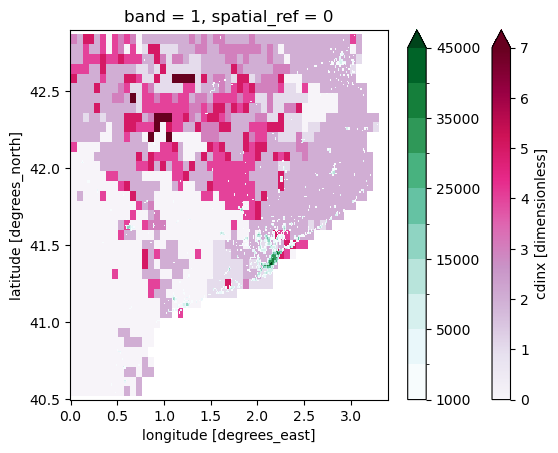

In [16]:
catalonia_cdi.cdinx.plot(cmap=plt.cm.PuRd, extend='max')

p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]
catalonia_population.plot(cmap=plt.cm.BuGn, levels=p_levels, extend='max')

This plot doesn't really help us doing climate risk assessemnt, so we can try to make a few changes to the map.

### Custom plot

Text(2.1686, 41.3874, '+ Barcelona')

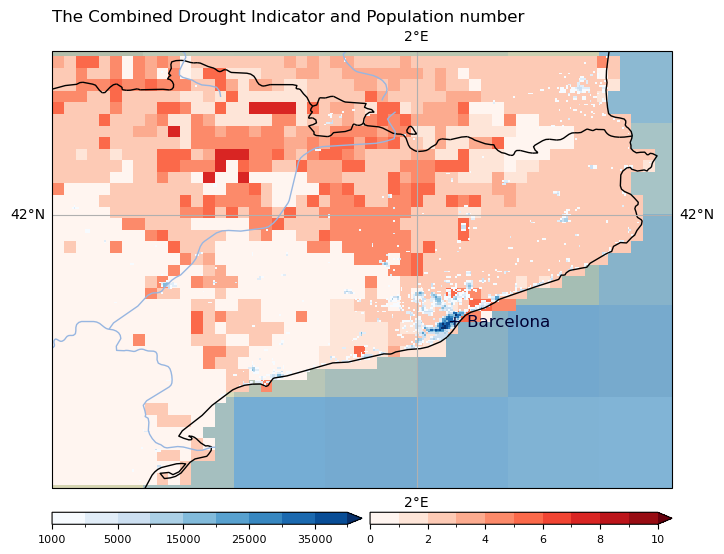

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
c_levels = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=plt.cm.Reds, levels=c_levels, extend='max', add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.Blues, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)



# Customize gridlines
gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator and Population number', loc = "left")

cax_p = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0-0.06,
                    ax.get_position().width/2,
                    0.02])

cax_c = fig.add_axes([ax.get_position().x0+ax.get_position().width/2+0.01,
                    ax.get_position().y0-0.06,
                    ax.get_position().width/2-0.01,
                    0.02])

# Plot horizontal colorbar on created axes
cbar_p = plt.colorbar(p, orientation="horizontal", cax=cax_p, ticks=[1000, 5000, 15000, 25000, 35000])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)

cbar_p.ax.tick_params(labelsize=8)
cbar_c.ax.tick_params(labelsize=8)

#----------- New code to add the text annotation -----------#

barcelona_lon, barcelona_lat = 2.1686, 41.3874
text_kwargs = dict(fontsize=12, color='#000032', transform=ccrs.PlateCarree())
p.axes.text(barcelona_lon, barcelona_lat, '+ Barcelona', horizontalalignment='left', **text_kwargs)

## Conclusions

In this workflow, we have seen how to explore, process and visualise the data needed to analyse drought and population data.

## Contributors
Milana Vuckovic, ECMWF  
Maurizio Mazzoleni, Vrije Universiteit Amsterdam

## Appendix I - Customised plot explained step by step

We will: 
- Add coastlines, rivers and country borders using cartopy
- Set distinct colour levels for CDI
- Remove the default colorbar and labels
- Add custom colorbars and title
- Add custom gridlines
- And finally add a label for Barcelona

### Background 
First we make a basic plot and set geographical extent to our domain. This way we can zoom in without having to manipulate the data.  
We can also add some (low resolution) background.

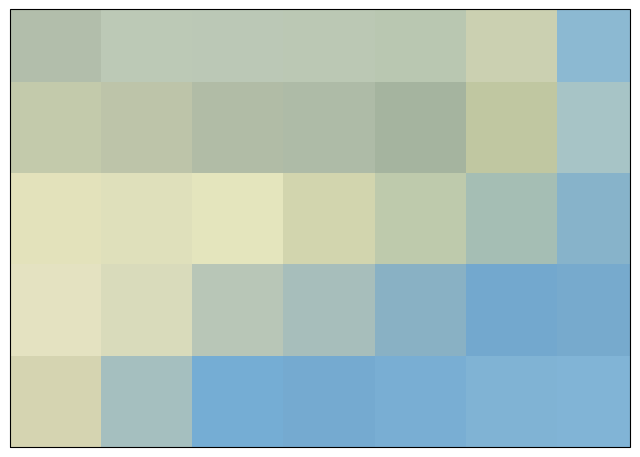

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add background image with orography
ax.stock_img()

### Adding the data
Next we add the data.  
Here we customize the levels on both plots. We will also remove the default colorbar and labels, so in the next step we can add our own.

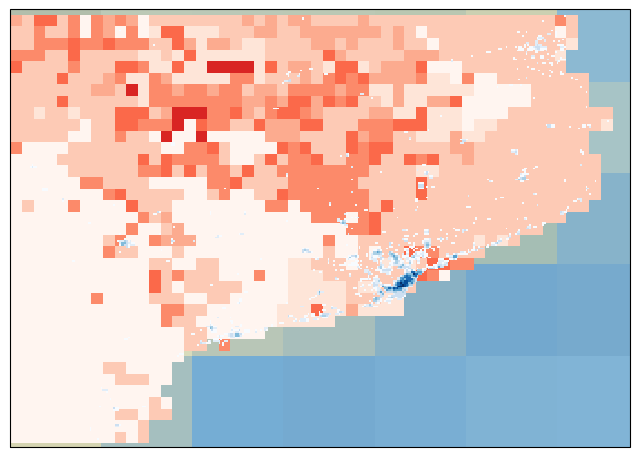

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()
#----------- New code to plot the data -----------#
# Plot CDI data
c_levels = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=plt.cm.Reds, levels=c_levels, extend='max', add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.Blues, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)

### Adding the geographical features
Next we add the gridlines, coastlines, rivers and country borders.

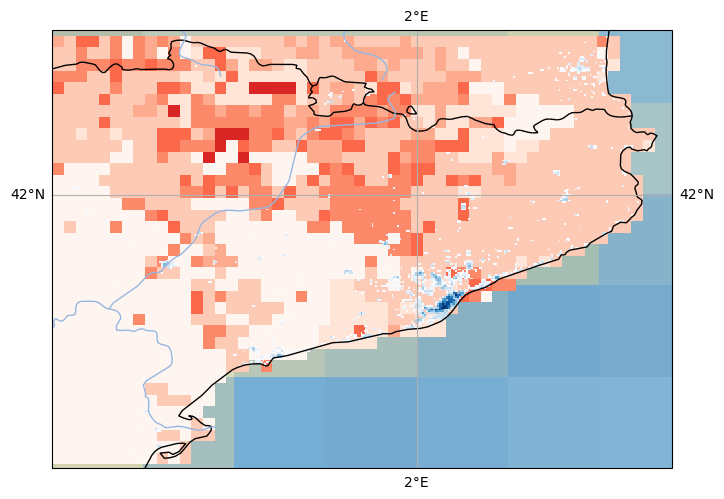

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
c_levels = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=plt.cm.Reds, levels=c_levels, extend='max', add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.Blues, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)

#----------- New code to customize gridlines -----------#

gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

### Adding the title
Then we add the title. 

Text(0.0, 1.0, 'The Combined Drought Indicator and Population number')

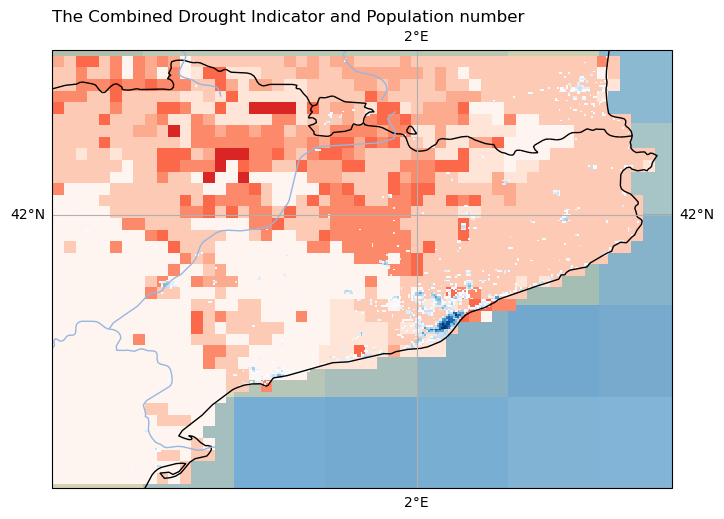

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
c_levels = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=plt.cm.Reds, levels=c_levels, extend='max', add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.Blues, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)

# Customize gridlines
gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

#----------- New code to add the title -----------#

plt.title('The Combined Drought Indicator and Population number', loc = "left")

### Adding the colorbar
It is a little bit tricky to add colorbars to where we want them.  
**cax_p** and **cax_c** variable define the positions and size of the colorbars. They get the default position and size of the colorbars and make them half as long and next to each other.  
In the end we also make the tick labels smaller.

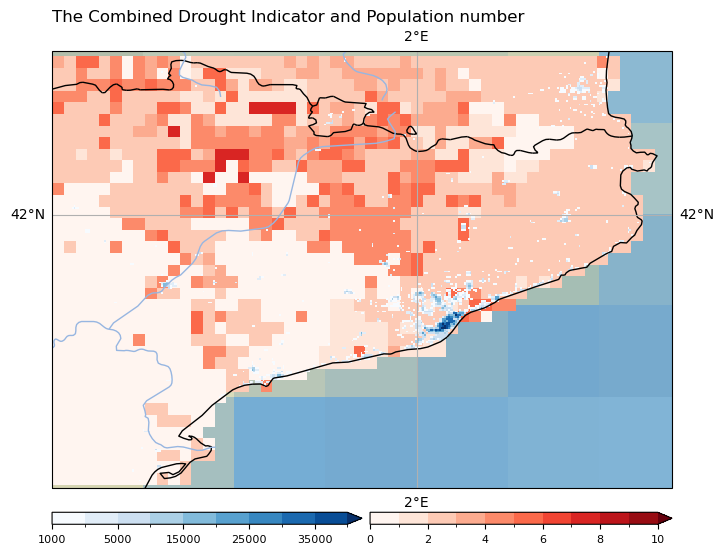

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
c_levels = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=plt.cm.Reds, levels=c_levels, extend='max', add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.Blues, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)



# Customize gridlines
gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator and Population number', loc = "left")

#----------- New code to add the horizontal colorbars -----------#

cax_p = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0-0.06,
                    ax.get_position().width/2,
                    0.02])

cax_c = fig.add_axes([ax.get_position().x0+ax.get_position().width/2+0.01,
                    ax.get_position().y0-0.06,
                    ax.get_position().width/2-0.01,
                    0.02])

# Plot horizontal colorbar on created axes
cbar_p = plt.colorbar(p, orientation="horizontal", cax=cax_p, ticks=[1000, 5000, 15000, 25000, 35000])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)

cbar_p.ax.tick_params(labelsize=8)
cbar_c.ax.tick_params(labelsize=8)

### Adding the custom text label

Finally we can add the label for Barcelona.

Text(2.1686, 41.3874, '+ Barcelona')

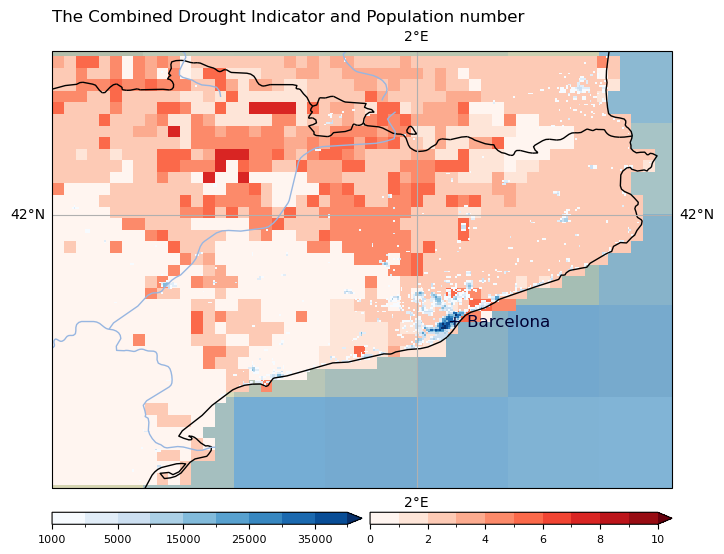

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
c_levels = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=plt.cm.Reds, levels=c_levels, extend='max', add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.Blues, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)



# Customize gridlines
gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator and Population number', loc = "left")

cax_p = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0-0.06,
                    ax.get_position().width/2,
                    0.02])

cax_c = fig.add_axes([ax.get_position().x0+ax.get_position().width/2+0.01,
                    ax.get_position().y0-0.06,
                    ax.get_position().width/2-0.01,
                    0.02])

# Plot horizontal colorbar on created axes
cbar_p = plt.colorbar(p, orientation="horizontal", cax=cax_p, ticks=[1000, 5000, 15000, 25000, 35000])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)

cbar_p.ax.tick_params(labelsize=8)
cbar_c.ax.tick_params(labelsize=8)

#----------- New code to add the text annotation -----------#

barcelona_lon, barcelona_lat = 2.1686, 41.3874
text_kwargs = dict(fontsize=12, color='#000032', transform=ccrs.PlateCarree())
p.axes.text(barcelona_lon, barcelona_lat, '+ Barcelona', horizontalalignment='left', **text_kwargs)